![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)

# Prompt Tuning for Multi-label Classification with watsonx

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.

# Overview

## Audience

This notebook is part of a series of notebooks, designed to guide you on how to utilize watsonx.ai Large Language Models (LLMs) for text classification.

The scenario presented in this notebook assumes you have a few hundred or thousand *labeled text elements* in a *multi-label* setup, 
that is, each text element is labeled to zero or more classes from a given taxonomy. Compared to the [Prompt tuning for multi-class classification notebook](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/1a8e5c23-1dc0-4f6e-b67f-eaac343a11f8?context=wx) that demonstrated the *multi-class* scenario where each text element is classfied to exactly one class, in this notebook we handle the case of generating a list of predicted classes, where the list can be either empty, contain one class, or multiple classes. 

Some familiarity with Python is helpful. This notebook runs with Python 3.10.

## Prompt Tuning

Full fine-tuning of LLMs requires significant resources. To this end, watsonx provides Prompt Tuning (PT), a parameter-efficient tuning method where the pre-trained model parameters are frozen and a soft prompt is trained on the labeled data provided. Compared to prompt-engineering, PT allows the LLMs to learn from much more examples, avoiding the prompt length limitation, and aiming at deeper adaptation to the given data. For more details, please refer to <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-methods.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">our documentation.</a>

## Learning goal

- The goal of this notebook is to provide an end-to-end step-by-step walkthrough of using Prompt Tuning in watsonx for multi-label classification, assuming labeled data exists, and demonstrating how to:
    - Upload a data asset
    - Setup and run prompt tuning
    - Deploy tuned model
    - Infer tuned model on test data
    - Evaluate model performance
- We provide advanced steps for making the best of your tuning in various scenarios. For example -
    - What to do if you have too many categories and they don't fit in the verbalizer?
    - How to initialize the soft prompt for classification?
- The notebook is backed by empirical evidence over 9 benchmark datasets showing an average improvement of ~25 points in macro-f1 compared to zero-shot classification with the same model, and ~23 points compared to zero-shot classification with a larger model (see details in the [Benchmark Results](#benchmark) section).

## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Load data](#load_data)
- [Initialize experiment](#experiment)
- [Run Prompt Tuning](#run_tuning)
- [Deploy](#deploy)
- [Run Foundation Models Inference on `watsonx.ai`](#inference)
- [Evaluate tuned model](#evaluation)
- [Benchmark Results](#benchmark)
- [Summary](#summary)

<a id="setup"></a>
# Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a Watson Machine Learning (WML) Service instance (information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>. A paid instance is required to use Tuning Studio).

## Install dependencies

In [1]:
!pip install ibm-watsonx-ai -U -q
!pip install scikit-learn -q
!pip install matplotlib -q
!pip install wget -q

## Import utility packages

In [2]:
import os
import getpass

### Watsonx API connection
This cell defines the credentials required to work with watsonx API for Foundation
Model inferencing.

**Action:** Provide the IBM Cloud URL and user API key. For details, see <a href="https://cloud.ibm.com/docs/account?topic=account-userapikey&interface=ui" target="_blank" rel="noopener no referrer">documentation</a>.

In [3]:
try:
    api_url = os.environ["API_URL"]
except KeyError:
    api_url = getpass.getpass("Please enter your watsonx.ai URL domain (hit enter): ")

Please enter your watsonx.ai URL domain (hit enter):  ········


In [4]:
try:
    api_key = os.environ["API_KEY"]
except KeyError:
    api_key = getpass.getpass("Please enter your watsonx.ai API key (hit enter): ")

Please enter your watsonx.ai API key (hit enter):  ········


## Define the project id

The Foundation Model requires a project id that provides the context for the call. We will try to obtain the id from the project in which this notebook runs. Otherwise, please provide the project id. To find your project id, select the project from the [project list](https://dataplatform.cloud.ibm.com/projects/?context=wx), and then take the project id from `Manage`->`General`->`Details`.

In [5]:
try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = getpass.getpass("Please enter your watsonx.ai Project ID (hit enter): ")

Please enter your watsonx.ai Project ID (hit enter):  ········


Create an instance of APIClient with authentication details, and set the project id.

In [6]:
credentials={
    "url": api_url,
    "apikey": api_key
}

In [7]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

In [8]:
client.set.default_project(project_id)

'SUCCESS'

<a id="load_data"></a>
# Load data

The recommended data size is between a few hundred and a few thousand examples. In case your data is much larger (e.g., 100k examples), you should probably randomly sample from it, to reduce runtime.

For more details read about <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-tuning-data.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">data formats</a> in our documentation.

Recommendations:
- Make sure class names are not too similar. E.g, `bank account` and `my bank account`. Class names which are too similar might confuse the model.
- Make sure each class is represented well enough. Models may have a hard time to predict classes that have a small number of examples in the train data.

## Use Legal contract clauses data

To illustrate the use of PT on multi-label data, we will use a subset of the Contract-NLI dataset, available in our repository (for more details about the dataset [click here](https://stanfordnlp.github.io/contract-nli/)). The license of the Contract-NLI data (cc-by-4.0) can be found [here](https://creativecommons.org/licenses/by/4.0/).
This dataset contains 5655 legal contracts labeled for 17 clause types. The dataset was originally curated for identifying entailment between premises and hypotheses in contracts. For the topical text classification task, we took the category of the hypothesis as the topic of each clause. We will use a sample of 1k clauses, and build a multi-label classifier for all the clause types.

## Use your own data

Alternatively, you can run this notebook with your own data. For this purpose, set the variable `use_your_own_data` to `True`. In the subsequent cell, set the path to your data in csv format, the text and label column names, the train asset filename and the path to the test file in csv format (if exists).

In [9]:
use_your_own_data = False

In [10]:
import wget

In [11]:
# downloading Contract NLI data
def download_contract_nli(filepath):
    url = f"https://raw.github.com/IBM/watson-machine-learning-samples/master/cloud/data/contract_nli/{filepath}"
    wget.download(url)

In [12]:
if not use_your_own_data:
    print("downloading contract_nli data")
    filepath = "train.csv"
    download_contract_nli(filepath)
    text_column = "text"
    label_column = "label"
    asset_train_filename = "Contract_NLI_train.json"
    
else:
    print("defining custom data parameters")
    filepath = "" # the path to your data
    text_column = "" # the column name for the input texts
    label_column = "" # the column name for gold labels
    asset_train_filename = "my_train.json" # the name of the file that is created for the train data asset (in json format)
    test_filepath = None # optionally, set a path to your test data for evaluation

downloading contract_nli data
100% [............................................................................] 306901 / 306901

We read a training file and preprocess the data. For Contract_NLI, the train set contains a random sample of 1k examples, 
and the labels have been preprocessed in advance by converting them to lower-case. If you use your own data, you can update this function with additional preprocessing steps for your dataset.

The data should be a csv file containing a column text - containing the text elements; and a column label - containing the class names of each text element. The label is a string with a list of all the matching class names. For example: a label with 2 classes ['sharing with third-parties', 'sharing with employees'], a label with one class ['limited use'], or with no class [].

In [13]:
import pandas as pd

In [14]:
# preprocessing Contract NLI data - update this function with relevant preprocessing of your data
def preprocess(df, text_column, label_column):
    print("preprocessing data")
    df = df.rename(columns={text_column: "input", label_column: "output"})
    df = df[['input', 'output']]
    # Here you can add some additional preprocessing of the data if needed, e.g.:
    # df.loc[:, "output"] = df["output"].apply(lambda l: l.replace("XXX", "YYY"))
    return df

In [15]:
df = pd.read_csv(filepath)
df = preprocess(df, text_column, label_column)
df.head()

preprocessing data


,input,output
0,(b) the fact that the Disclosing Party and the...,['confidentiality of agreement']
1,6.3 Termination of this Agreement shall not af...,['survival of obligations']
2,For a period of five (5) years from the date h...,['no solicitation']
3,Buyer will not circumvent Seller and/or Broker...,['no solicitation']
4,10.1.3 until such time as you or any of your c...,['no solicitation']


We create a data asset for training.

In [16]:
import json

In [17]:
assets = client.data_assets.get_details()['resources']
assets = [a for a in assets if a['metadata']['name'] == asset_train_filename]

In [18]:
def get_demo_train_data(df):
    return df.loc[:999, :]

In [19]:
if len(assets) == 0:
    print("\ntrain asset does not exist")
    if not use_your_own_data:
        train_df = get_demo_train_data(df)
    else:
        train_df = df
    data = train_df.to_dict("records")
    with open(asset_train_filename, "w") as f:
        json.dump(data, f)
    train_asset = client.data_assets.create(name=asset_train_filename, file_path=asset_train_filename)
else:
    print("\ntrain asset exists")
    train_asset = assets[0]
    asset_uid = client.data_assets.get_uid(train_asset)
    content = client.data_assets.get_content(asset_uid).decode("utf-8")
    train_df = pd.read_json(content, orient="records")


train asset exists


We extract the list of classes from the labels in the training data and sort the class names by their prior probability from low to high.

In [20]:
from collections import Counter

In [21]:
sorted_classes_by_freq = Counter([ll for l in train_df["output"] for ll in eval(l)]).most_common()
print(f"Frequency of classes in the train set: {sorted_classes_by_freq}")
class_names = [c[0] for c in sorted_classes_by_freq][::-1]
classes_with_less_than_twenty_examples = [c for c in sorted_classes_by_freq if c[1] < 20]
if len(classes_with_less_than_twenty_examples) > 0:
    print("Note, the following classes have less than 20 examples in the train set. This may harm their performance:")
    print(classes_with_less_than_twenty_examples)
print("Class names:", class_names)

Frequency of classes in the train set: [('no licensing', 125), ('limited use', 123), ('permissible acquirement of similar information', 121), ('sharing with employees', 114), ('permissible development of similar information', 110), ('notice on compelled disclosure', 98), ('sharing with third-parties', 96), ('survival of obligations', 94), ('inclusion of verbally conveyed information', 74), ('confidentiality of agreement', 67), ('return of confidential information', 48), ('permissible post-agreement possession', 42), ('no solicitation', 36), ('explicit identification', 31), ('permissible copy', 23), ('no reverse engineering', 19), ('none-inclusion of non-technical information', 3)]
Note, the following classes have less than 20 examples in the train set. This may harm their performance:
[('no reverse engineering', 19), ('none-inclusion of non-technical information', 3)]
Class names: ['none-inclusion of non-technical information', 'no reverse engineering', 'permissible copy', 'explicit id

We also calculate some statistics on the labels in the input data

In [22]:
import ast

In [23]:
def get_data_stats(df):
    labels_list = df["output"].apply(lambda x: ast.literal_eval(x))
    print('num_samples:', len(df))

    num_samples = len(df)
    num_no_label = sum([1 if len(labels) == 0 else 0 for labels in labels_list])
    num_multi_label = sum([1 if len(labels)>1 else 0 for labels in labels_list])
    num_with_label = num_samples - num_no_label
    p = 0
    if num_with_label:
        p = num_multi_label/num_with_label   
    
    print(num_samples, 'with_label:', num_with_label, 'no_label:', num_no_label, 'multi label:', num_multi_label, 'percentage of multilabel:', p)

In [24]:
get_data_stats(train_df)

num_samples: 1000
1000 with_label: 1000 no_label: 0 multi label: 189 percentage of multilabel: 0.189


We define a `DataConnection` instance for the training data. This instance will be used as reference when running PT later.

In [25]:
train_asset_id = client.data_assets.get_id(train_asset)

In [26]:
from ibm_watsonx_ai.helpers import DataConnection

In [27]:
data_conn = DataConnection(data_asset_id=train_asset_id)

<a id="experiment"></a>
# Initialize experiment

We initialize an instance of `TuneExperiment` using the `project_id`.

In [28]:
from ibm_watsonx_ai.experiment import TuneExperiment

In [29]:
experiment = TuneExperiment(credentials, project_id=project_id)

## Initialize a verbalizer

We now define the verbalizer to be used in training. We use a multi-label instruction to guide the model, and set two verbalizers: 
- An instruction that includes the list of possible class names (*recommended*)
- An alternative instruction which does not contain the class names, thus requiring less tokens but typically results in somewhat lower performance.

As a subsequent step we will determine the actual verbalizer to use on these data based on dynamic selection of the list of class names to be included in the prompt.

The main element of the verbalizer is the `instruction` that describes the task at hand. In multi-label classification, besides specifying the classification to the different classes, we add an instruction on how handle the case that the text does not belong to any of the classes. In the example below, we use the following instruction `Return a list of all the matching categories or an empty list (“[]”)`. 

Note that we experimented with other instruction variants, (e.g. `Return a list of all the matching categories or “none”`), and on the benchmark data, with a large amount of training data (1k samples per dataset), there was no much impact to the different phrasing of the no-label case. 


In [30]:
def get_verbalizer_with_class_names(class_names):
    class_names_list = [f'"{c}"' for c in class_names]
    instruction = f'Classify the text into one or more of the following categories: {", ".join(class_names_list)}. ' \
                   'Return a list of all the matching categories or an empty list ("[]").'
    input_prefix = 'Text: '
    output_prefix = 'Categories: '
    verbalizer = instruction + ' ' + input_prefix + ' {{input}} ' + output_prefix
    return verbalizer

In [31]:
def get_verbalizer_no_class_names():
    instruction = f'Classify the text into one or more categories. ' \
                   'Return a list of all the matching categories or an empty list ("[]"). '
    input_prefix = 'Text: '
    output_prefix = 'Categories: '
    verbalizer = instruction + ' ' + input_prefix + ' {{input}} ' + output_prefix
    return verbalizer

## Determine which verbalizer to use

The default token limit for inputs (verbalizer + text) for tuning is 256 tokens. Thus, the actual input might not fit entirely per this limit if we have many classes in the dataset, and/or the input texts are relatively long.

The following cell estimates the length of the verbalizer in tokens.

If the verbalizer with all class names takes up more than 256 tokens, it means they won't fit in the input and the tuning may produce poor performance. In this case, we either remove some classes from the prompt or fallback to the verbalizer without the class names. If there is enough room for some of the classes, we include a subset of the class names starting from the classes with the low prior probability to fit the input length limit requirement. In the example shown here with the Contract-NLI data, there are 17 classes and all of them are included in the prompt. But with other datasets, this approach can be useful.

Note: texts which will not fit the token limit are trimmed automatically, keeping the text from the start and trimming the end. You may want to consider trimming the texts in advance to keep the most important parts of your data, e.g., if in your data the content at the end of the text is more important than the opening.


### Count the number of tokens in the verbalizer

In [32]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

In [33]:
generate_params_for_verbalizer = {
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.DECODING_METHOD: 'greedy',
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TRUNCATE_INPUT_TOKENS: 4096,
    GenParams.RETURN_OPTIONS: {'input_text': False, 'generated_tokens': False, 'input_tokens': True, 'token_logprobs': False, 'token_ranks': False, 'top_n_tokens': 0}
}

In [34]:
from ibm_watsonx_ai.foundation_models import ModelInference
from ibm_watsonx_ai.foundation_models.utils.enums import ModelTypes

In [35]:
base_model_for_verbalizer = ModelInference(
    model_id=ModelTypes.FLAN_T5_XL,
    params=generate_params_for_verbalizer,
    api_client=client
)

In [36]:
def get_verbalizer_num_tokens(verbalizer):
    batch = [verbalizer.replace("{{input}}", "")]
    predictions = base_model_for_verbalizer.generate_text(prompt=batch, raw_response=True)
    verbalizer_num_tokens = predictions[0]['results'][0]['input_token_count']
    return verbalizer_num_tokens

### Create the actual verbalizer

In [37]:
def get_text_length_estimate(df):
    texts = df.input.tolist()
    text_token_count = [len(t.split()) * 1.5 for t in texts]
    avg_text_length = sum(text_token_count)/len(text_token_count)
    return avg_text_length

In [38]:
token_limit = 256

def get_verbalizer(df, class_names, max_num_classes=0):
    # estimate the average input text length
    avg_text_length = get_text_length_estimate(df)
    print("average train text length estimate:", avg_text_length, "tokens")
    
    if max_num_classes:
        # fixed number of classes names in the prompt
        num_classes_in_prompt = max_num_classes
        class_names_in_prompt = class_names[:num_classes_in_prompt]
        verbalizer = get_verbalizer_with_class_names(class_names_in_prompt)
    else:   
        # dynamic prompt: calculate the verbalizer token length estimate 
        for num_classes_in_prompt in range(len(class_names)+1)[::-1]:
            class_names_in_prompt = class_names[:num_classes_in_prompt]
            verbalizer = get_verbalizer_with_class_names(class_names_in_prompt)
            verbalizer_token_count = get_verbalizer_num_tokens(verbalizer)
            if (verbalizer_token_count + avg_text_length) <= token_limit:
                print(f"num classes in prompt: {num_classes_in_prompt}, Verbalizer length: {verbalizer_token_count}")
                print(f"num classes in prompt: {num_classes_in_prompt}, Tokens in verbalizer remaining for texts: {token_limit-verbalizer_token_count}")
                break
        if token_limit - verbalizer_token_count < avg_text_length:
            print(f"If the number of tokens remaining for texts is much smaller than their actual length, this might harm performance.")
            class_names_in_prompt = []
            verbalizer = get_verbalizer_no_class_names()
    print("total num classes:", len(class_names), "num classes in prompt:", len(class_names_in_prompt))
    return verbalizer, class_names_in_prompt

In [39]:
verbalizer, class_names_in_prompt = get_verbalizer(train_df, class_names)
print(verbalizer)

average train text length estimate: 60.114 tokens
num classes in prompt: 17, Verbalizer length: 169
num classes in prompt: 17, Tokens in verbalizer remaining for texts: 87
total num classes: 17 num classes in prompt: 17
Classify the text into one or more of the following categories: "none-inclusion of non-technical information", "no reverse engineering", "permissible copy", "explicit identification", "no solicitation", "permissible post-agreement possession", "return of confidential information", "confidentiality of agreement", "inclusion of verbally conveyed information", "survival of obligations", "sharing with third-parties", "notice on compelled disclosure", "permissible development of similar information", "sharing with employees", "permissible acquirement of similar information", "limited use", "no licensing". Return a list of all the matching categories or an empty list ("[]"). Text:  {{input}} Categories: 


## Set the soft prompt initialization text

The process of PT trains a `soft prompt`- a list of 100 token embeddings - instead of the entire model. To achieve satisfactory results with the model tuned in this notebook (`google/flan-t5-xl`), it is recommended to initialize the soft prompt tokens with the following:
* An instruction that is relevant for the task. 
* The candidate classes sorted by their frequency in the train set.
* In certain cases (and only if the instruction and the candidate classes are together substansially shorter than 100 tokens), it could be helpful to provide a longer instruction, to fill out the 100 tokens of the soft prompt.

This initialization presumably allows a more semantically meaningful starting point for the soft prompt embeddings. We set the inialization text in the `soft_prompt_initialization_text` parameter.

In [40]:
class_names_list = [f'"{c}"' for c in class_names]
soft_prompt_initialization_text = f'Classify the text into one or more of the following categories: {", ".join(class_names_list)}. ' \
                                  'Return a list of all the matching categories or an empty list ("[]").'
print(f"The soft prompt initialization text: \n{soft_prompt_initialization_text}\n")

The soft prompt initialization text: 
Classify the text into one or more of the following categories: "none-inclusion of non-technical information", "no reverse engineering", "permissible copy", "explicit identification", "no solicitation", "permissible post-agreement possession", "return of confidential information", "confidentiality of agreement", "inclusion of verbally conveyed information", "survival of obligations", "sharing with third-parties", "notice on compelled disclosure", "permissible development of similar information", "sharing with employees", "permissible acquirement of similar information", "limited use", "no licensing". Return a list of all the matching categories or an empty list ("[]").



## Define prompt tuner

We define the `prompt_tuner` parameters, including the verbalizer and the initialization text. Tuning is currently available for `google/flan-t5-xl`.

Note: We set the number of epochs to 50 (`num_epochs` parameter), as this usually provided the best results in our experiments. You may want to consider decreasing the number of epochs to save on run-time, especially if your dataset contains more than 1k elements, with potential decrease in performance.

In [41]:
from ibm_watsonx_ai.foundation_models.utils.enums import PromptTuningInitMethods

In [42]:
prompt_tuner = experiment.prompt_tuner(name="sample SDK run auto_update True on Contract NLI",
                                       task_id=experiment.Tasks.CLASSIFICATION,
                                       base_model=ModelTypes.FLAN_T5_XL,
                                       accumulate_steps=16,
                                       batch_size=16,
                                       learning_rate=0.3,
                                       max_input_tokens=token_limit,
                                       max_output_tokens=100,
                                       num_epochs=50,
                                       tuning_type=experiment.PromptTuningTypes.PT,
                                       verbalizer=verbalizer,
                                       auto_update_model=True,
                                       init_method=PromptTuningInitMethods.TEXT,
                                       init_text=soft_prompt_initialization_text
                                       )

In [43]:
prompt_tuner.get_params()

{'base_model': {'model_id': 'google/flan-t5-xl'},
 'accumulate_steps': 16,
 'batch_size': 16,
 'init_method': 'text',
 'init_text': 'Classify the text into one or more of the following categories: "none-inclusion of non-technical information", "no reverse engineering", "permissible copy", "explicit identification", "no solicitation", "permissible post-agreement possession", "return of confidential information", "confidentiality of agreement", "inclusion of verbally conveyed information", "survival of obligations", "sharing with third-parties", "notice on compelled disclosure", "permissible development of similar information", "sharing with employees", "permissible acquirement of similar information", "limited use", "no licensing". Return a list of all the matching categories or an empty list ("[]").',
 'learning_rate': 0.3,
 'max_input_tokens': 256,
 'max_output_tokens': 100,
 'num_epochs': 50,
 'task_id': 'classification',
 'tuning_type': 'prompt_tuning',
 'verbalizer': 'Classify the 

<a id="run_tuning"></a>
# Run Prompt Tuning

We run a prompt tuning process of foundation models on top of the training data referenced by DataConnection (tuning may take some time).

By setting the `background_mode` parameter to `True`, the prompt tuning process will run in the background.

In [44]:
tuning_details = prompt_tuner.run(training_data_references=[data_conn], background_mode=True)

PT over 1k examples of the Contract NLI data takes about 55 minutes. If background_mode is set to True, we use the following utility function to probe the status of training. Run this cell, and it will finish when training is completed.

In [45]:
print(tuning_details)

{'metadata': {'created_at': '2024-02-04T06:19:41.548Z', 'description': 'Prompt tuning with SDK', 'id': 'ad9d987e-a329-416d-b049-65627d117610', 'modified_at': '2024-02-04T06:19:41.548Z', 'name': 'sample SDK run auto_update True on Contract NLI', 'project_id': 'ccf0f4b1-8cf3-4e32-94d6-6323e8c6ca6c', 'tags': ['prompt_tuning', 'wx_prompt_tune.ece1f050-d2d3-4c0e-b5ca-6c6ba8efdc7c']}, 'entity': {'auto_update_model': True, 'description': 'Prompt tuning with SDK', 'name': 'sample SDK run auto_update True on Contract NLI', 'project_id': 'ccf0f4b1-8cf3-4e32-94d6-6323e8c6ca6c', 'prompt_tuning': {'accumulate_steps': 16, 'base_model': {'model_id': 'google/flan-t5-xl'}, 'batch_size': 16, 'init_method': 'text', 'init_text': 'Classify the text into one or more of the following categories: "none-inclusion of non-technical information", "no reverse engineering", "permissible copy", "explicit identification", "no solicitation", "permissible post-agreement possession", "return of confidential information"

In [46]:
import time

In [47]:
model_id = tuning_details['metadata']['id']

In [48]:
def wait_till_model_is_ready(tuning_details):
    while True:
        status = prompt_tuner.get_run_status()
        print(f'Model {model_id} is {status}')
        if status == 'completed':
            break
        elif status not in ['initializing', 'pending', 'running']:
            raise ValueError(f'Unexpected tune status: {status}')
        time.sleep(60)

In [49]:
wait_till_model_is_ready(tuning_details)

Model ad9d987e-a329-416d-b049-65627d117610 is pending
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b049-65627d117610 is running
Model ad9d987e-a329-416d-b04

<a id="run_details"></a>
## Prompt Tuning details

Get a summary of the tuning process.

In [50]:
prompt_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_ad9d987e-a329-416d-b049-65627d117610,[prompt_tuning],google/flan-t5-xl,True,50,0.111584


Plot the learning curves. The left most curve shows the loss over the epochs. A good tuning process is one where the loss gradually decreases as training progresses.

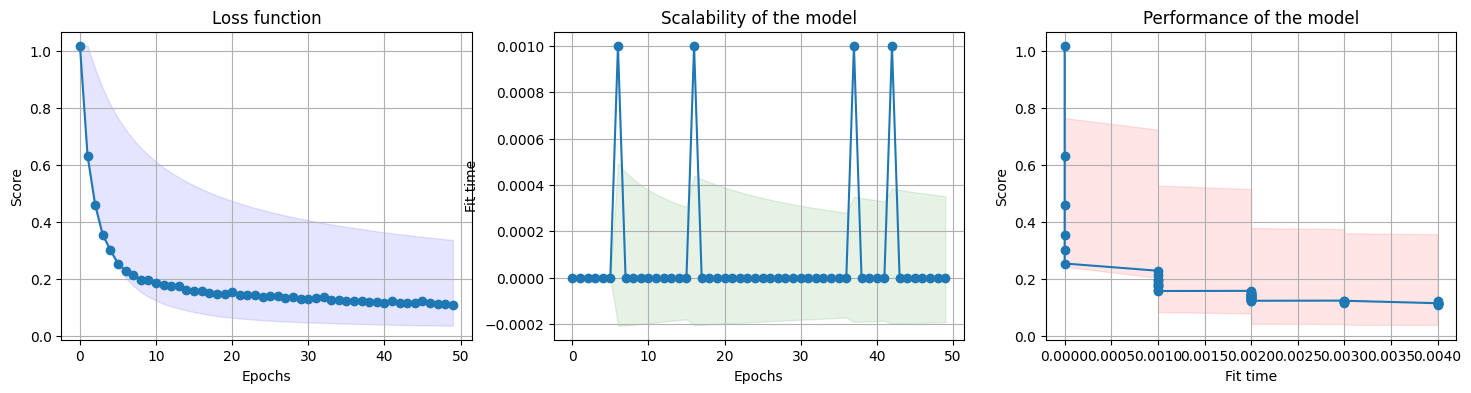

In [51]:
prompt_tuner.plot_learning_curve()

<a id="deploy"></a>
# Deploy

We deploy the model using the `model_id` variable.

In [52]:
model_id = prompt_tuner.get_run_details()['entity']['model_id']
print(model_id)

870ad2d6-430f-4504-ab32-15621e923e54


In [53]:
from datetime import datetime

In [54]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "PT DEPLOYMENT SDK - project",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"pt_sdk_deployment_{datetime.utcnow().strftime('%Y_%m_%d_%H%M%S')}"
}
deployment_details = client.deployments.create(model_id, meta_props)



#######################################################################################

Synchronous deployment creation for uid: '870ad2d6-430f-4504-ab32-15621e923e54' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='5903a8a4-a684-4d19-a398-d8c6b37b0563'
------------------------------------------------------------------------------------------------




We store the deployment id, which will be used for inference.

In [ ]:
deployment_details

In [56]:
deployment_id = client.deployments.get_id(deployment_details)
print(deployment_id)

5903a8a4-a684-4d19-a398-d8c6b37b0563


<a id="inference"></a>
# Run Foundation Models Inference on watsonx.ai


We define the generation parameters. 

- We use `greedy` decoding method because we want the model to return the most probable class names for the given text.
- The overall token limit for inference of the tuned model is 4096 (inputs and outputs combined). 100 of them are saved for the tuned soft prompt, and 100 for the output, so 3896 tokens remain for the input. We set `TRUNCATE_INPUT_TOKENS` to 3895 to trim inputs which are longer than that.

In [57]:
generate_params = {
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.DECODING_METHOD: 'greedy',
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TRUNCATE_INPUT_TOKENS: 3895
}

We define an instance of ModelInference using the deployment_id and the generation parameters.

In [58]:
tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=generate_params,
    api_client=client
)

## Run inference

If you chose to run with the demo data, we take the test data from the original Contract_NLI dataframe. Otherwise, the test data is taken from the path specified in the variable `test_filepath` in the cell `Use your own data`.

Note: We perform the same preprocessing for the test set as done for the train set. It is assumed they share identical column names.

In [59]:
def get_demo_test_data(df):
    filepath = "test.csv"
    download_contract_nli(filepath)
    return pd.read_csv(filepath)

In [60]:
def get_test_data(filepath):
    return pd.read_csv(filepath)

In [61]:
if not use_your_own_data:
    test_df = get_demo_test_data(df)
else:
    if test_filepath is None:
        raise Exception("you need set a path to a test file to continue (in cell \"Use your own data\")")
    test_df = get_test_data(test_filepath)
test_df = preprocess(test_df, text_column, label_column)

100% [............................................................................] 225045 / 225045preprocessing data


In case the verbalizer used in tuning contained the class names, there is no need to add them in inference. On the other hand, if the verbalizer without the class names was selected for tuning, we add them in inference.

In [62]:
if len(class_names_in_prompt) > 0:
    prompts_batch = test_df["input"].tolist()
else:
    prompts_batch = [get_verbalizer_with_class_names(class_names).replace("{{input}}", text) for text in test_df["input"]]
labels = test_df["output"].tolist()

We infer the tuned model over the test data.

Note: In case inference fails, try waiting a few seconds and running the cell again. If it fails, you may want to re-run the `Deploy` section and then try inference again.

In [63]:
import time

In [65]:
start = time.time()
print(f"Running inference on {len(prompts_batch)} examples")
predictions = tuned_model.generate_text(prompt=prompts_batch)
end = time.time()
print(f"elapsed time: {end - start}")

Running inference on 732 examples
elapsed time: 110.59867405891418


## Post-processing the generated text

We post-process the predicted text by calling the `post_processing` function which contains two steps. 

1) In some cases, the predicted output string is not produced in a valid list format. To overcome these extreme cases, we post-process the predicted text string by calling the `post_process_prediction` function. This function transform the generated output text into a valid list of strings for further evaluation.

2) Occasionally, the output of the model may yield class names which are not part of the original class list. For this purpose we use a utility function from the difflib package to find the most similar class to each predicted class in the the generated text before calculating the performance metrics. If none is found, we return an empty list.

In [66]:
def normalize_generated_text(t):
    if len(t) == 0:
        t = '[]'
    if not t.startswith('['):
        t = '[' + t
    if t != '[]':
        if t.endswith(','):
            t = t[:-1]
        if t.endswith(', '):
            t = t[:-2]
        if t.endswith(', "'):
            t = t[:-3]
        if not t.endswith(']'):
            t += ']'
        if not t.startswith('["') and not t.startswith("['"):
            t = t.replace('[', '["')
        if not t.endswith('"]') and not t.endswith("']"):
            t = t.replace(']', '"]')
    return t

In [67]:
def post_process_prediction(predictions):
    processed_text = []
    for p in predictions:
        norm_p = normalize_generated_text(p)
        try:
            ast.literal_eval(norm_p)
        except Exception as ex:
            print(p, "--->", norm_p, ex)
            norm_p = '[]'
        processed_text.append(norm_p)
    return processed_text 

In [68]:
import difflib

In [69]:
def get_close_matches(prediction, class_names):
    predictions = ast.literal_eval(prediction)
    res = []
    if not isinstance(predictions, list):
        print('Unable to parse generated result', predictions)
        return str(res)
    for c in predictions:
        p = difflib.get_close_matches(c, class_names, n=1)
        if len(p) == 1:
            res.append(p[0])
    return str(res)

In [70]:
def post_processing(predictions):
    predictions_p1 = post_process_prediction(predictions)
    predictions_p2 = [get_close_matches(p, class_names) for p in predictions_p1]
    return predictions_p2

In [71]:
predictions = post_processing(predictions)

<a id="evaluation"></a>
# Evaluate tuned model

We evaluate the predictions with respect to the labels. We calculate accuracy, micro-f1, macro-f1 and f1 per class.


In [72]:
from sklearn.metrics import accuracy_score, f1_score

In [73]:
def get_labels_in_binary_form(labels, class_names):
    return [1 * (cls in labels) for cls in class_names]

In [74]:
def get_metrics(labels, predictions):
    binary_labels = [get_labels_in_binary_form(ast.literal_eval(l), class_names) for l in labels]
    binary_preds = [get_labels_in_binary_form(ast.literal_eval(p), class_names) for p in predictions]
    f1_per_class = f1_score(binary_labels, binary_preds, average=None)
    
    return {
        f'num_samples': f'{len(labels)}',
        f'accuracy': f'{accuracy_score(binary_labels, binary_preds)*100:.2f}',
        f'micro_f1': f'{f1_score(binary_labels, binary_preds, average="micro")*100:.2f}',
        f'macro_f1': f'{f1_score(binary_labels, binary_preds, average="macro")*100:.2f}',
        f'f1_per_class': (pd.Series(f1_per_class, index=class_names)*100.).round(2),
    }

In [75]:
performance = get_metrics(labels, predictions)
print(performance)

{'num_samples': '732', 'accuracy': '74.73', 'micro_f1': '80.50', 'macro_f1': '75.90', 'f1_per_class': none-inclusion of non-technical information         0.00
no reverse engineering                            100.00
permissible copy                                   70.00
explicit identification                            78.57
no solicitation                                    75.56
permissible post-agreement possession              66.67
return of confidential information                 82.93
confidentiality of agreement                       78.33
inclusion of verbally conveyed information         77.05
survival of obligations                            81.38
sharing with third-parties                         74.83
notice on compelled disclosure                     87.94
permissible development of similar information     86.39
sharing with employees                             82.08
permissible acquirement of similar information     73.99
limited use                                

## Compare to base model

This cell is optional, and is used to compare the tuned model to the same model in a zero-shot setup. On the dataset we are using in this notebook, the gain with the tuned model is around ~43 macro-f1 points.

We initialize the `ModelInference` class with base model, and infer over the test data.

We need to provide the base model with the zero-shot prompt for the task. We use the prompt that is defined in the `verbalizer` with all the class names sorted by alphabetic order.

In [76]:
generate_params = {
    GenParams.MAX_NEW_TOKENS: 100,
    GenParams.DECODING_METHOD: 'greedy',
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.TRUNCATE_INPUT_TOKENS: 4096
}

In [77]:
base_model = ModelInference(
    model_id=ModelTypes.FLAN_T5_XL,
    params=generate_params,
    api_client=client
)

In [78]:
class_names_sorted_alpha = sorted(class_names)
base_prompts_batch = [get_verbalizer_with_class_names(class_names_sorted_alpha).replace("{{input}}", text) for text in test_df["input"]]

In [79]:
base_predictions = base_model.generate_text(prompt=base_prompts_batch)
base_predictions = post_processing(base_predictions)

In [80]:
base_performance = get_metrics(labels, base_predictions)
print(base_performance)

{'num_samples': '732', 'accuracy': '25.00', 'micro_f1': '35.88', 'macro_f1': '32.30', 'f1_per_class': none-inclusion of non-technical information        0.00
no reverse engineering                            93.33
permissible copy                                   0.00
explicit identification                            6.25
no solicitation                                   58.54
permissible post-agreement possession              0.00
return of confidential information                69.44
confidentiality of agreement                      26.92
inclusion of verbally conveyed information         0.00
survival of obligations                           51.79
sharing with third-parties                         8.00
notice on compelled disclosure                    71.56
permissible development of similar information    13.64
sharing with employees                            35.19
permissible acquirement of similar information     6.00
limited use                                       57.94
no

Similarly, we run the zero-shot setup with a larger model (Flan-t5-xxl) for comparison with the fine-tuned model.

In [81]:
base_model_xxl = ModelInference(
    model_id=ModelTypes.FLAN_T5_XXL,
    params=generate_params,
    api_client=client
)

In [82]:
base_predictions_xxl = base_model_xxl.generate_text(prompt=base_prompts_batch)
base_predictions_xxl = post_processing(base_predictions_xxl)

In [83]:
base_performance_xxl = get_metrics(labels, base_predictions_xxl)
print(base_performance_xxl)

{'num_samples': '732', 'accuracy': '40.16', 'micro_f1': '43.25', 'macro_f1': '37.99', 'f1_per_class': none-inclusion of non-technical information        0.00
no reverse engineering                            64.00
permissible copy                                  10.53
explicit identification                           41.03
no solicitation                                   64.29
permissible post-agreement possession              0.00
return of confidential information                51.35
confidentiality of agreement                      47.33
inclusion of verbally conveyed information        10.96
survival of obligations                           57.85
sharing with third-parties                        12.20
notice on compelled disclosure                    84.72
permissible development of similar information    44.64
sharing with employees                            25.49
permissible acquirement of similar information    16.22
limited use                                       43.37
no

<a id="benchmark"></a>
# Benchmark Results

We compared the performance achieved by running PT as described in this notebook to zero-shot classification using Flan-t5-xl / xxl on 9 multi-label benchmark datasets. We report `macro-f1` results. As depicted in the table below, PT results provide a significant improvement in all datasets.

Watson Emotion and Customer Care Tweets Emotion, Contract Clause 1 and 2 are IBM internal datasets, while the rest are publicly available.
The CUAD dataset has a relatively large number of classes, which do not fit the PT train input token limit. For running PT over that dataset we use the prompt with the dynamic selection of 18 least probable class names, as described in `get_verbalizer`. For all other datasets we use all the class names in the prompt. For zero-shot we use the prompt with class names throughout.

For each dataset we present the number of classes and the fraction of the examples in the data with more than one label (`Multi label`), with one class (`Single label`), and with no classes (`No label`).

The PT training is using 1k samples and tested on maximum of 1k samples for each dataset. Experiments with more training data (e.g., 2k samples from each dataset) show a gain of ~1-2 points on average. In this notebook, we use 1k samples due to runtime considerations. 


| Dataset | Number of classes | Multi label | Single label | No label | Flan-t5-xl PT (this notebook) | Flan-t5-xl zero-shot | Flan-t5-xxl zero-shot |
| --- | :-: | :-:| :-: | :-: | :-: | :-: | :-: |
|watson_emotion|  5 | 0.0	| 95.0 |  5.0 | 57.94 |	53.51 |	53.98 |  
|unfair_tos    | 8  | 1.0   | 10.0 | 89.0 | 76.83 |	28.80 |	26.32 |
|contract_clause_1|  4  | 1.4  | 14.9 | 83.7 | 50.44 |	36.22 |	37.46 | 	
|financial_news       | 20 | 5.6	| 72.9 |	21.5 | 78.70 |	54.74 |	57.29 | 
|cuad          | 37 | 10.7	| 89.3	| 0.0 | 57.63 |	43.48 |	45.76| 	
|financial_events     | 18 | 15.1	| 42.7 |	42.2 | 58.02 |	36.78 |	38.66 | 
|contract-nli  | 20 | 19.8	| 80.2 |	0.0 | 74.06 | 35.89 |	31.15 | 	
|customer_care_tweets_emotion      |   8 | 23.2 |	59.1 |	17.7 | 41.39 | 20.16 |	32.44 | 
|contract_clause_2          |  23 | 29.4 |	70.6 |	0.0 | 56.86 | 21.33 | 27.75 | 	
|**Average**      |    |  | | | **61.32** | **36.77** | **38.98**  | 

<a id="summary"></a>
# Summary

Congratulations, you have successfully trained a model using watsonx Prompt Tuning!

Check out our <a href="https://ibm.github.io/watson-machine-learning-sdk/" target="_blank" rel="noopener no referrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts.

**Author: Orith Toledo-Ronen**, LM Utilization Team, IBM Research.

Copyright © 2023 IBM. This notebook and its source code are released under the terms of the MIT License.